# Network analysis in the city of Beira.

### Measuring travel time from all populated places to key services:
    1) population: WorldPop, for consistency with the earlier drainage analysis for this same location.
    2) commercial center: downtown. (“Praça do Município da Beira” (-19.834084150189714, 34.83575811502723)).
    3) markets: OpenStreetMap markets where amenity='marketplace' OR 'supermarket'
    4) medical facilities: OpenStreetMap hospitals and clinics
    5) education: OpenStreetMap K-12 schools. 
    6) road network: OpenStreetMap roads and footpaths, with modifications from before (A) and after (B) the infrastructure project.

#### Travel time:
    A) Driving time before the infrastructure rehabilitation project from closest road node to population cell (dataset 1), to the closest road node to a destination (datasets 2-5) (closeness measured by road segments speeds).
    
    B) Driving time after the infrastructure rehabilitation project from closest road node to population cell (dataset 1), to the closest road node to a destination (datasets 2-5) (closeness measured by road segments speeds). 

#### Unmeasured aspects:
The following should be considered in more sophisticated iterations of the model:
    1) walking time from population cell to the closest road node.
    2) disrupt the network with a flood scenario.
    3) disrupt the network with pre- and post-project bridge status.
    
Services are expected to be proximal to the road network, so no measure is taken between road and service.


### The outputs:
Each populated cell has 2 travel time values per facility: the time it takes to get to the facility before and after the infrastructure project. Population-adjusted aggregation to the EA level can be performed in R.

In [1]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\grace\\GIS\\analytics--beira 2020'

In [2]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
import GOSTnet as gn
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point

# Might not use these
import fiona
import peartree
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [4]:
pth = os.path.join(GISFolder, "outputs")
pth

'C:\\Users\\grace\\GIS\\analytics--beira 2020\\outputs'

### Prepare and clean the data

In [ ]:
# OSM road network is in WGS84. Projected each dataset to match.
# Multi-point shapefiles don't read well. Re-created shapefile from csv with geopandas for each offending file.

In [5]:
os.path.exists('downtown.csv')

True

In [6]:
dfD = os.path.join(GISFolder, "downtown.csv") # D as in Downtown
dfD = pd.read_csv(dfD)
geometry = [Point(xy) for xy in zip(dfD.x, dfD.y)]
crs = {'init': 'epsg:4326'} 
inD = GeoDataFrame(dfD, crs=crs, geometry=geometry) 
inD.to_file(driver='ESRI Shapefile', filename='downtown.shp') 
# 188 observations.
inD

C:\Users\grace\Anaconda3\envs\access\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,name,x,y,geometry
0,0,Praça do Município da Beira,34.835758,-19.834084,POINT (34.83576 -19.83408)


In [5]:
os.path.exists('morocco_data/hosp_clinic.csv')

True

In [6]:
dfH = os.path.join(pth, "hosp_clinic.csv")
dfH = pd.read_csv(dfH)
geometry = [Point(xy) for xy in zip(dfH.X, dfH.Y)]
crs = {'init': 'epsg:4326'} 
inH = GeoDataFrame(dfH, crs=crs, geometry=geometry) # H as in Health or Hospital
inH.to_file(driver='ESRI Shapefile', filename='health.shp') 
# 188 observations.
inH

C:\Users\grace\Anaconda3\envs\access\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,X,Y,osm_id,amenity,healthcare,name,speciality,beds,staff_docto,staff_nurse,health_amen,dispensing,wheelchair,emergency,addr_city,geometry
0,-5.346908,35.586766,1596542299,hospital,NaN,Clinique Rif,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-5.34691 35.58677)
1,-4.621278,34.669540,1786951782,hospital,NaN,Clinique Khlalfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-4.62128 34.66954)
2,-6.850408,33.983897,1824603903,hospital,NaN,Hopital Ibn Sina /CHU Ibn SIna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,POINT (-6.85041 33.98390)
3,-5.807340,35.770945,1839628546,clinic,NaN,Clinique Tingis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-5.80734 35.77095)
4,-9.766079,31.507898,2031101163,hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-9.76608 31.50790)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,-5.308233,35.889142,7374757009,clinic,NaN,Clinica Septem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-5.30823 35.88914)
184,-6.529468,34.007628,7571651896,hospital,hospital,Cabinet Dr Siham BENALI OUMJOUD,general,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sidi Allal El Bahraoui ⵙⵉⴷⵉ ⵄⵍⵍⴰⵍ ⴰⴱⵃⵔⴰⵡⵉ سيدي...,POINT (-6.52947 34.00763)
185,-1.924292,34.672193,7602911285,clinic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.92429 34.67219)
186,-1.923575,34.673155,7602911185,hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.92358 34.67315)


In [8]:
dfPop = os.path.join(GISFolder, "worldpop.csv")
dfPop = pd.read_csv(dfPop)
geometry = [Point(xy) for xy in zip(dfPop.X, dfPop.Y)]
crs = {'init': 'epsg:4326'} 
inV = GeoDataFrame(dfPop, crs=crs, geometry=geometry) # V as in Village or Ville.
inV.to_file(driver='ESRI Shapefile', filename='worldpop.shp') 
# 12018 observations.
inV

,ID,X,Y,Population,geometry
0,1,34.870833,-19.850833,43.312202,POINT (34.87083 -19.85083)
1,2,34.871667,-19.850833,43.280464,POINT (34.87167 -19.85083)
2,3,34.872500,-19.850833,43.325081,POINT (34.87250 -19.85083)
3,4,34.873333,-19.850833,43.440170,POINT (34.87333 -19.85083)
4,5,34.874167,-19.850833,43.070862,POINT (34.87417 -19.85083)
...,...,...,...,...,...
12013,12014,34.955833,-19.769166,2.807988,POINT (34.95583 -19.76917)
12014,12015,34.956667,-19.769166,2.672740,POINT (34.95667 -19.76917)
12015,12016,34.957500,-19.769166,2.617378,POINT (34.95750 -19.76917)
12016,12017,34.958333,-19.769166,2.559380,POINT (34.95833 -19.76917)


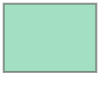

In [9]:
aoi = r'clipping_boundary.shp' 
shp = gpd.read_file(os.path.join(GISFolder, aoi))
bound = shp.geometry.iloc[0]
bound # Check that it's the shape expected from the boundary file.

In [12]:
# Check to confirm each file so far is the same coordinate system.
inD.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# If starting new session, load data from disc.
inputPop = os.path.join(GISFolder, "worldpop.shp")
inputD = os.path.join(GISFolder, "downtown.shp")

In [10]:
inV = gpd.read_file(inputPop) 
inD = gpd.read_file(inputD) 

In [13]:
networkType = 'drive'

In [14]:
inV.head()

,ID,X,Y,Population,geometry
0,1,34.870833,-19.850833,43.312202,POINT (34.87083 -19.85083)
1,2,34.871667,-19.850833,43.280464,POINT (34.87167 -19.85083)
2,3,34.872500,-19.850833,43.325081,POINT (34.87250 -19.85083)
3,4,34.873333,-19.850833,43.440170,POINT (34.87333 -19.85083)
4,5,34.874167,-19.850833,43.070862,POINT (34.87417 -19.85083)


### Finish modifications to OSM driving network.
Travel measured in length (meters).

In [22]:
# This is the OSM road network as a shapefile. It already contains the additional columns related to the infrastructure project.
# We need to put all speed types into a single column so that GOSTNets can call from it for the graph creation.
roads = os.path.join(GISFolder, "roads_rehab.shp")
roads = gpd.read_file(roads)

In [23]:
roads.tail(20)
# "fclass" is the original OSM road classification.
# "r_before" and "r_after" are the more accurate road classes before and after the infrastructure project.
# The problem is that the latter two variables are NULL on roads where no roadwork happened.

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,r_before,r_after,n_order,typework,loc_onmap,geometry
5557,887676819,5122,residential,None,None,B,0,0,F,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86658 -19.83928, 34.86666 -19.8..."
5558,887679158,5114,secondary,None,None,B,0,0,F,F,NaN,NaN,NaN,None,None,"LINESTRING (34.85645 -19.83026, 34.85642 -19.8..."
5559,887795677,5114,secondary,Rua Dom Jaime Pedro Gonçalves,None,B,0,0,F,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86854 -19.82890, 34.86854 -19.8..."
5560,887795678,5114,secondary,Rua Dom Jaime Pedro Gonçalves,None,B,0,1,T,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86863 -19.82874, 34.86854 -19.8..."
5561,887795679,5114,secondary,Rua Alfredo Lawley,None,B,0,0,F,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86702 -19.83164, 34.86694 -19.8..."
5562,887795680,5154,path,None,None,B,0,1,T,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86784 -19.80946, 34.86796 -19.8..."
5563,887795681,5122,residential,None,None,B,0,0,F,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86624 -19.80880, 34.86631 -19.8..."
5564,887795682,5122,residential,None,None,B,0,1,T,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86619 -19.80894, 34.86624 -19.8..."
5565,887795683,5121,unclassified,Maraza Basin / V7,None,B,0,0,F,F,2.0,1.0,2.0,new construction,5,"LINESTRING (34.86361 -19.80887, 34.86364 -19.8..."
5566,887795684,5121,unclassified,Maraza Basin / V7,None,B,0,1,T,F,NaN,NaN,NaN,None,None,"LINESTRING (34.86354 -19.80896, 34.86361 -19.8..."


In [24]:
roads["r_before"].fillna(roads["fclass"], inplace=True)

In [26]:
roads.tail(20)
# Now all of the NaN values in "r_before" are replaced with their corresponding "fclass" value.

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,r_before,r_after,n_order,typework,loc_onmap,geometry
5557,887676819,5122,residential,None,None,B,0,0,F,F,residential,NaN,NaN,None,None,"LINESTRING (34.86658 -19.83928, 34.86666 -19.8..."
5558,887679158,5114,secondary,None,None,B,0,0,F,F,secondary,NaN,NaN,None,None,"LINESTRING (34.85645 -19.83026, 34.85642 -19.8..."
5559,887795677,5114,secondary,Rua Dom Jaime Pedro Gonçalves,None,B,0,0,F,F,secondary,NaN,NaN,None,None,"LINESTRING (34.86854 -19.82890, 34.86854 -19.8..."
5560,887795678,5114,secondary,Rua Dom Jaime Pedro Gonçalves,None,B,0,1,T,F,secondary,NaN,NaN,None,None,"LINESTRING (34.86863 -19.82874, 34.86854 -19.8..."
5561,887795679,5114,secondary,Rua Alfredo Lawley,None,B,0,0,F,F,secondary,NaN,NaN,None,None,"LINESTRING (34.86702 -19.83164, 34.86694 -19.8..."
5562,887795680,5154,path,None,None,B,0,1,T,F,path,NaN,NaN,None,None,"LINESTRING (34.86784 -19.80946, 34.86796 -19.8..."
5563,887795681,5122,residential,None,None,B,0,0,F,F,residential,NaN,NaN,None,None,"LINESTRING (34.86624 -19.80880, 34.86631 -19.8..."
5564,887795682,5122,residential,None,None,B,0,1,T,F,residential,NaN,NaN,None,None,"LINESTRING (34.86619 -19.80894, 34.86624 -19.8..."
5565,887795683,5121,unclassified,Maraza Basin / V7,None,B,0,0,F,F,2,1.0,2.0,new construction,5,"LINESTRING (34.86361 -19.80887, 34.86364 -19.8..."
5566,887795684,5121,unclassified,Maraza Basin / V7,None,B,0,1,T,F,unclassified,NaN,NaN,None,None,"LINESTRING (34.86354 -19.80896, 34.86361 -19.8..."


In [27]:
# Repeat for post-project road classes.
roads["r_after"].fillna(roads["fclass"], inplace=True)
roads.tail(20)

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,r_before,r_after,n_order,typework,loc_onmap,geometry
5557,887676819,5122,residential,None,None,B,0,0,F,F,residential,residential,NaN,None,None,"LINESTRING (34.86658 -19.83928, 34.86666 -19.8..."
5558,887679158,5114,secondary,None,None,B,0,0,F,F,secondary,secondary,NaN,None,None,"LINESTRING (34.85645 -19.83026, 34.85642 -19.8..."
5559,887795677,5114,secondary,Rua Dom Jaime Pedro Gonçalves,None,B,0,0,F,F,secondary,secondary,NaN,None,None,"LINESTRING (34.86854 -19.82890, 34.86854 -19.8..."
5560,887795678,5114,secondary,Rua Dom Jaime Pedro Gonçalves,None,B,0,1,T,F,secondary,secondary,NaN,None,None,"LINESTRING (34.86863 -19.82874, 34.86854 -19.8..."
5561,887795679,5114,secondary,Rua Alfredo Lawley,None,B,0,0,F,F,secondary,secondary,NaN,None,None,"LINESTRING (34.86702 -19.83164, 34.86694 -19.8..."
5562,887795680,5154,path,None,None,B,0,1,T,F,path,path,NaN,None,None,"LINESTRING (34.86784 -19.80946, 34.86796 -19.8..."
5563,887795681,5122,residential,None,None,B,0,0,F,F,residential,residential,NaN,None,None,"LINESTRING (34.86624 -19.80880, 34.86631 -19.8..."
5564,887795682,5122,residential,None,None,B,0,1,T,F,residential,residential,NaN,None,None,"LINESTRING (34.86619 -19.80894, 34.86624 -19.8..."
5565,887795683,5121,unclassified,Maraza Basin / V7,None,B,0,0,F,F,2,1,2.0,new construction,5,"LINESTRING (34.86361 -19.80887, 34.86364 -19.8..."
5566,887795684,5121,unclassified,Maraza Basin / V7,None,B,0,1,T,F,unclassified,unclassified,NaN,None,None,"LINESTRING (34.86354 -19.80896, 34.86361 -19.8..."


### Convert driving network to graph object

In [31]:
roads.reset_index(level=0, inplace=True)
# Because we split some of the OSM lines to assign project road class values, some "osm_id"s are duplicated.
# We will need a unique ID for each road segment later on, so here we assign a unique ID using the file's "index".

In [32]:
roads.head()

,index,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,r_before,r_after,n_order,typework,loc_onmap,geometry
0,0,44784554,5141,service,None,None,F,0,0,F,F,service,service,NaN,None,None,"LINESTRING (34.89976 -19.80094, 34.89966 -19.8..."
1,1,44785076,5115,tertiary,None,None,F,0,0,F,F,tertiary,tertiary,NaN,None,None,"LINESTRING (34.87607 -19.85083, 34.87602 -19.8..."
2,2,44785077,5115,tertiary,None,None,F,0,0,F,F,tertiary,tertiary,NaN,None,None,"LINESTRING (34.87606 -19.85055, 34.87628 -19.8..."
3,3,44785078,5115,tertiary,None,None,F,0,0,F,F,tertiary,tertiary,NaN,None,None,"LINESTRING (34.87673 -19.85047, 34.87642 -19.8..."
4,4,44785079,5122,residential,None,None,B,0,0,F,F,residential,residential,NaN,None,None,"LINESTRING (34.87522 -19.84858, 34.87556 -19.8..."


In [28]:
gDrive = ox.graph_from_polygon(bound, network_type= 'drive')
# Note: length is measured in meters.

In [29]:
gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_edge_gdf = gn.edge_gdf_from_graph(gDrive)
# Takes just a few seconds.

C:\Users\grace\Anaconda3\envs\access\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [30]:
gDrive_edge_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12452 entries, 0 to 12451
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   stnode    12452 non-null  int64   
 1   endnode   12452 non-null  int64   
 2   highway   12452 non-null  object  
 3   bridge    84 non-null     object  
 4   name      1025 non-null   object  
 5   oneway    12452 non-null  bool    
 6   maxspeed  256 non-null    object  
 7   ref       195 non-null    object  
 8   lanes     271 non-null    object  
 9   osmid     12452 non-null  object  
 10  junction  92 non-null     object  
 11  length    12452 non-null  float64 
 12  geometry  12452 non-null  geometry
dtypes: bool(1), float64(1), geometry(1), int64(2), object(8)
memory usage: 1.2+ MB


In [34]:
# What we care about from gDrive is the start and end nodes, and the osmid
gDrive_edge_gdf = gDrive_edge_gdf.drop(['highway','oneway','lanes','ref','maxspeed','junction','name','length','bridge'], axis=1)

In [36]:
gDrive_edge_gdf.head()

,stnode,endnode,osmid,geometry
0,567924681,1934771035,820923407,"LINESTRING (34.87673 -19.85047, 34.87737 -19.8..."
1,567924681,4095037852,44785078,"LINESTRING (34.87673 -19.85047, 34.87642 -19.8..."
2,567924698,3328284864,326208102,"LINESTRING (34.89401 -19.79724, 34.89359 -19.7..."
3,567924698,567924713,"[839392844, 839392845]","LINESTRING (34.89401 -19.79724, 34.89519 -19.7..."
4,567924698,5637982031,839392845,"LINESTRING (34.89401 -19.79724, 34.89274 -19.7..."


In [39]:
gDrive2 = roads.merge(gDrive_edge_gdf, left_on = "osm_id", right_on = "osmid")

TypeError: unhashable type: 'list'

In [ ]:
gTime = nx.from_pandas_edgelist(
    roads,
    source="stnode",
    target="endnode",
    edge_attr=True,
)

In [28]:
# Save all road nodes (points on the road) to file.
gDrive_node_gdf = gn.node_gdf_from_graph(gDrive)
gDrive_node_gdf.to_csv(os.path.join(pth, 'drive_dist_node.csv'))

C:\Users\grace\Anaconda3\envs\access\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [22]:
?gn.convert_network_to_time

In [29]:
speed_dict = {
                'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type = 'drive', speed_dict = speed_dict)
# Note: time is in seconds.

#### Save road nodes and road edges to file. Edges contains time measure

In [30]:
edges = gn.edge_gdf_from_graph(gTime)
nodes = gn.node_gdf_from_graph(gTime)
# 1,326,476 edges
# 473,100 nodes

In [32]:
nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 473100 entries, 0 to 473099
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   node_ID   473100 non-null  int64   
 1   y         473100 non-null  float64 
 2   osmid     473100 non-null  int64   
 3   highway   2582 non-null    object  
 4   ref       293 non-null     object  
 5   x         473100 non-null  float64 
 6   geometry  473100 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 28.9+ MB


In [33]:
edges.to_csv(os.path.join(pth, 'drive_time_edge.csv'))
nodes.to_csv(os.path.join(pth, 'drive_time_node.csv'))

In [34]:
# Save a pickle of the graph with the time measure for easy recall.
gn.save(gTime, 'gTime', '', edges = False, nodes = False)

In [32]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("gTime.pickle")

### Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [35]:
inV.dtypes

index          float64
Unnamed_ 0     float64
ID             float64
X              float64
Y                int64
landscan20       int64
pid            float64
Shape_Leng     float64
Shape_Area      object
ID1_COMMUN     float64
cid             object
geometry      geometry
dtype: object

In [ ]:
?gn.pandana_snap

In [30]:
!pip list # gostnets was at version 1.0.1. scipy is where the below error occurred in pandana_snap, and it's at 1.5.2

Package                       Version
----------------------------- -------------------
affine                        2.3.0
argon2-cffi                   20.1.0
asn1crypto                    1.4.0
async-generator               1.10
attrs                         20.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.1
bleach                        3.2.1
boltons                       20.0.0
boto3                         1.15.1
botocore                      1.18.1
bottle                        0.12.18
brotlipy                      0.7.0
cchardet                      2.1.4
certifi                       2020.6.20
cffi                          1.14.3
chardet                       3.0.4
click                         7.1.2
click-plugins                 1.1.1
cligj                         0.5.0
colorama                      0.4.3
cryptography                  2.5
cycler                        0.10.0
cytoolz                       0.10.1
decorator                     4.4.2
d

In [31]:
!pip install --user --upgrade scipy
# upgraded to 1.5.4

Requirement already up-to-date: scipy in c:\users\grace\anaconda3\envs\access\lib\site-packages (1.5.4)


In [ ]:
inVsnap = gn.pandana_snap(gTime, inV, source_crs = 'epsg:4326', target_crs = 'epsg:32630', add_dist_to_node_col = True)
inVsnap.to_csv('inVsnap.csv', index=True)

C:\Users\grace\Anaconda3\envs\access\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\grace\Anaconda3\envs\access\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\grace\Anaconda3\envs\access\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization m

In [ ]:
inVsnap.head()

In [ ]:
inH.dtypes

In [ ]:
inHsnap = gn.pandana_snap(gTime, inH, source_crs = 'epsg:4326', target_crs = 'epsg:32630', add_dist_to_node_col = True)
inHsnap.to_csv('inHsnap.csv', index=True)

In [ ]:
inHsnap.head()

### Map elevation onto road nodes and villages.

In [6]:
# If starting new session, load road nodes from disk.
nodes = os.path.join(pth, "drive_time_node.csv")
nodes = gpd.read_file(nodes)

C:\Users\grace\Anaconda3\envs\access\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\grace\\GIS\\morocco\\morocco_data'

In [ ]:
nodes.head()

In [ ]:
# Ensure nodes coordinates and unique ID field are in the right data type.
nodes['x'] = nodes['x'].astype('float')
nodes['y'] = nodes['y'].astype('float')
nodes['osmid'] = nodes['osmid'].astype(int)

In [ ]:
def add_elevation(df, x, y, srtm_pth):
    # walk all tiles, find path

    tiles = []
    for root, folder, files in os.walk(os.path.join(srtm_pth,'high_res')):
        for f in files:
            if f[-3:] == 'hgt':
                tiles.append(f[:-4])

    # load dictionary of tiles
    arrs = {}
    for t in tiles:
         arrs[t] = rt.open(srtm_pth+r'\high_res\{}.hgt\{}.hgt'.format(t, t), 'r')
    # assign a code
    uniques = []
    df['code'] = 'placeholder'
    def tile_code(z):
        E = str(abs(z[x])+1)[:2]
        N = str(abs(z[y]))[:2]
        return 'N{}W0{}'.format(N, E)
    df['code'] = df.apply(lambda z: tile_code(z), axis = 1)
    unique_codes = list(set(df['code'].unique()))

    z = {}
    # Match on High Precision Elevation
    property_name = 'elevation'
    for code in unique_codes:

        df2 = df.copy()
        df2 = df2.loc[df2['code'] == code]
        dataset = arrs[code]
        b = dataset.bounds
        datasetBoundary = box(b[0], b[1], b[2], b[3])
        selKeys = []
        selPts = []
        for index, row in df2.iterrows():
            selPts.append((row[x],row[y]))
            selKeys.append(index)
        raster_values = list(dataset.sample(selPts))
        raster_values = [x[0] for x in raster_values]
        # generate new dictionary of {node ID: raster values}
        z.update(zip(selKeys, raster_values))
    
    elev_df = pd.DataFrame.from_dict(z, orient='index')
    elev_df.columns = ['elevation']
    
    missing = elev_df.copy()
    missing = missing.loc[missing.elevation < 0]
    
    print('missing: %s' % len(missing))
    
    if len(missing) > 0:
        missing_df = df.copy()
        missing_df = missing_df.loc[missing.index]
        low_res_tifpath = os.path.join(srtm_pth, 'clipped', 'W100N40.GIF')
        dataset = rt.open(low_res_tifpath, 'r')
        b = dataset.bounds
        datasetBoundary = box(b[0], b[1], b[2], b[3])
        selKeys = []
        selPts = []
        for index, row in missing_df.iterrows():
            if Point(row[x], row[y]).intersects(datasetBoundary):
                selPts.append((row[x],row[y]))
                selKeys.append(index)
        raster_values = list(dataset.sample(selPts))
        raster_values = [x[0] for x in raster_values]
        z.update(zip(selKeys, raster_values))

        elev_df = pd.DataFrame.from_dict(z, orient='index')
        elev_df.columns = ['elevation']
    df['point_elev'] = elev_df['elevation']
    df = df.drop('code', axis = 1)
    return df

In [ ]:
nodes_elev = add_elevation(nodes, "x", "y", pth) # Takes a few minutes.

#### Origin points are different from road nodes. Need elevation for both.

In [ ]:
# Using inVsnap was giving the error: 'Series' object has no attribute 'x'. 
    # To work around this, merged the new NN fields from snap onto the original inV.
inV.dtypes
inVsnap2 = pd.merge(inV[['wpop', 'xmid', 'wid', 'municipio', 'geometry', 'x', 'y']], 
                    inVsnap[['wid', 'NN', 'NN_dist']], on='wid', how='left')
inVsnap2.dtypes
inVsnap2.isna().sum()
V_elev = add_elevation(inVsnap2, "x", "y", pth) # Takes maybe 10 minutes.

In [ ]:
# Save to file.
nodes_elev.to_csv(os.path.join(pth, 'nodes_elev.csv'))
V_elev.to_csv(os.path.join(pth, 'V_elev.csv'))

In [ ]:
# Reload from disk.
nodes_elev = os.path.join(pth, "nodes_elev.csv")
nodes_elev = gpd.read_file(nodes_elev)
V_elev = os.path.join(pth, "V_elev.csv")
V_elev = gpd.read_file(v_elev)

### Elevation-adjusted walk time to road.

In [42]:
nodes_elev.head()

,node_ID,ref,y,x,osmid,highway,geometry,point_elev
0,238026752,NaN,18.261897,-66.050248,238026752,NaN,POINT (-66.050248 18.261897),93
1,238026754,NaN,18.427812,-65.990280,238026754,traffic_signals,POINT (-65.9902804 18.4278116),6
2,238026757,NaN,18.427999,-65.990606,238026757,NaN,POINT (-65.99060559999999 18.4279988),5
3,238026760,NaN,18.236478,-66.025554,238026760,NaN,POINT (-66.025554 18.236478),65
4,238026764,NaN,18.236759,-66.025735,238026764,traffic_signals,POINT (-66.025735 18.236759),65


In [43]:
# generate_walktimes function takes a single dataframe, and all numbers must be float.
# Merging the two datasets and cleaning up any naming issues.
nodes_elev.rename(columns={'node_ID':'NN'}, inplace=True)

In [44]:
zvalues = pd.merge(V_elev, nodes_elev, on='NN', how='left')
zvalues.head(5)

,wpop,xmid,wid,municipio,geometry_x,x_x,y_x,NN,NN_dist,point_elev_x,ref,y_y,x_y,osmid,highway,geometry_y,point_elev_y
0,0.818646,0.0,1,Adjuntas,POINT (-66.79433386730727 18.24980920687696),-66.794334,18.249809,239148931,380.618736,486,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
1,0.731308,0.0,2,Adjuntas,POINT (-66.79350056730728 18.24980920687693),-66.793501,18.249809,239148931,447.535794,516,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
2,0.642141,0.0,3,Adjuntas,POINT (-66.79266726730728 18.24980920687693),-66.792667,18.249809,239148931,520.852340,548,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
3,0.612746,0.0,4,Adjuntas,POINT (-66.79183396730728 18.24980920687692),-66.791834,18.249809,239148931,598.220028,557,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572
4,0.699177,0.0,5,Adjuntas,POINT (-66.79016736730729 18.24980920687696),-66.790167,18.249809,239077120,726.478000,555,NaN,18.249867,-66.783309,239077120,NaN,POINT (-66.783309 18.249867),639


In [46]:
zvalues.rename(columns={'point_elev_y':'node_elev'}, inplace=True)
zvalues.rename(columns={'point_elev_x':'point_elev'}, inplace=True)
zvalues.dtypes

wpop          float64
xmid          float64
wid             int64
municipio      object
geometry_x     object
x_x           float64
y_x           float64
NN              int64
NN_dist       float64
point_elev      int64
ref            object
y_y           float64
x_y           float64
osmid           int32
highway        object
geometry_y     object
node_elev       int64
dtype: object

In [47]:
zvalues['point_elev'] = zvalues['point_elev'].astype(float)
zvalues['node_elev'] = zvalues['node_elev'].astype(float)
zvalues.dtypes

wpop          float64
xmid          float64
wid             int64
municipio      object
geometry_x     object
x_x           float64
y_x           float64
NN              int64
NN_dist       float64
point_elev    float64
ref            object
y_y           float64
x_y           float64
osmid           int32
highway        object
geometry_y     object
node_elev     float64
dtype: object

In [49]:
# Time is in seconds.
def generate_walktimes(df, start = 'point_elev', end = 'node_elev', dist = 'NN_dist', max_walkspeed = 6, min_speed = 0.1):
    # Tobler's hiking function: https://en.wikipedia.org/wiki/Tobler%27s_hiking_function
    def speed(incline_ratio, max_speed):
        walkspeed = max_speed * np.exp(-3.5 * abs(incline_ratio + 0.05)) 
        return walkspeed

    speeds = {}
    times = {}

    for index, data in df.iterrows():
        if data[dist] > 0:
            delta_elevation = data[end] - data[start]
            incline_ratio = delta_elevation / data[dist]
            speed_kmph = speed(incline_ratio = incline_ratio, max_speed = max_walkspeed)
            speed_kmph = max(speed_kmph, min_speed)
            speeds[index] = (speed_kmph)
            times[index] = (data[dist] / 1000 * 3600 / speed_kmph)

    speed_df = pd.DataFrame.from_dict(speeds, orient = 'index')
    time_df = pd.DataFrame.from_dict(times, orient = 'index')

    df['walkspeed'] = speed_df[0]
    df['walk_time'] = time_df[0]
    
    return df

In [50]:
zwalk = generate_walktimes(zvalues) # Takes about 10 minutes.
zwalk.head(5)

,wpop,xmid,wid,municipio,geometry_x,x_x,y_x,NN,NN_dist,point_elev,ref,y_y,x_y,osmid,highway,geometry_y,node_elev,walkspeed,walk_time
0,0.818646,0.0,1,Adjuntas,POINT (-66.79433386730727 18.24980920687696),-66.794334,18.249809,239148931,380.618736,486.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,2.284031,599.916314
1,0.731308,0.0,2,Adjuntas,POINT (-66.79350056730728 18.24980920687693),-66.793501,18.249809,239148931,447.535794,516.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,3.250490,495.657267
2,0.642141,0.0,3,Adjuntas,POINT (-66.79266726730728 18.24980920687693),-66.792667,18.249809,239148931,520.852340,548.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,4.286563,437.429293
3,0.612746,0.0,4,Adjuntas,POINT (-66.79183396730728 18.24980920687692),-66.791834,18.249809,239148931,598.220028,557.0,NaN,18.252231,-66.796881,239148931,NaN,POINT (-66.796881 18.252231),572.0,4.613557,466.796478
4,0.699177,0.0,5,Adjuntas,POINT (-66.79016736730729 18.24980920687696),-66.790167,18.249809,239077120,726.478000,555.0,NaN,18.249867,-66.783309,239077120,NaN,POINT (-66.783309 18.249867),639.0,3.360424,778.271009


In [51]:
zwalk.to_csv('zwalk_full.csv', index=True) # Takes a few minutes.

In [52]:
# Clean up the file for only the necessary columns.
zwalk2 = zwalk.drop(columns=['geometry_x', 'x_x', 'y_x', 'NN_dist', 'point_elev', 
                                   'x_y', 'y_y', 'ref', 'highway', 'geometry_y', 'node_elev'])
zwalk2.dtypes

wpop         float64
xmid         float64
wid            int64
municipio     object
NN             int64
osmid          int32
walkspeed    float64
walk_time    float64
dtype: object

In [53]:
# Convert from seconds to minutes
zwalk2['walk_time'] = zwalk2['walk_time'] / 60 
zwalk2.head()

,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time
0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605
1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954
2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488
3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941
4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183


In [54]:
# Save to disk.
zwalk2.to_csv('zwalk.csv', index=True)

### Create travel time values for the road nodes nearest to each service.

Using calculate_OD.

In [ ]:
gTime = nx.read_gpickle("gTime.pickle")

In [ ]:
# If starting a new session, load from file.
inVsnap = os.path.join(pth, "inVsnap.csv")
inVsnap = pd.read_csv(inVsnap)
inHsnap = os.path.join(pth, "inHsnap.csv")
inHsnap = pd.read_csv(inHsnap)

In [8]:
# We only need to find the origin-destination pairs for nodes closest to the origins and services,
# and some nodes will be the nearest for more than one service (and definitely for multiple origins).
origins = list(inVsnap.NN.unique())

In [9]:
# Commented how to do this if more than one destination type.
# listE = list(inEsnap.NN.unique()) 
# listM = list(inMsnap.NN.unique()) 
listH = list(inHsnap.NN.unique()) 
# destslist = listE + listM + listH
# dests = list(set(destslist))

In [10]:
len(origins) # 142,421 unique nearest nodes.

142421

In [ ]:
# len(dests) # 1,011 unique nearest nodes.

In [12]:
len(listH)

69

In [13]:
fail_value = 999999999 # If there is no shortest path, the OD pair will be assigned the fail value.

In [14]:
gn.example_edge(gTime)

(238026752, 238075156, {'osmid': 22137085, 'name': 'Calle F', 'highway': 'residential', 'oneway': False, 'length': 108.717, 'time': 19.569059999999997, 'mode': 'drive'})


In [15]:
OD = gn.calculate_OD(gTime, origins, dests, fail_value, weight = 'time')
# Took maybe 10 min.

In [16]:
OD_df = pd.DataFrame(OD, index = origins, columns = dests)

In [17]:
OD_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142421 entries, 239148931 to 238880909
Columns: 1011 entries, 233324546 to 238196735
dtypes: float64(1011)
memory usage: 1.1 GB


In [18]:
OD_df.tail()

,233324546,4155721731,238944260,239097861,239310852,4155721735,238962698,238981133,238845965,238549012,...,238372836,238995433,763959274,238055405,238071790,2149629933,238018545,4155721720,237981689,238196735
238421388,16460.909360,9043.596294,15744.659018,5208.659860,2342.319710,9050.396574,4839.264443,5076.230410,10351.917856,9372.719094,...,2921.715720,15689.594294,4980.377940,3438.475700,5774.741691,5272.487050,4844.558670,9072.961134,5887.507214,7355.777344
238402093,16463.189540,9045.876474,15746.939198,5210.940040,2344.599890,9052.676754,4841.544623,5078.510590,10354.198036,9374.999274,...,2923.995900,15691.874474,4982.658120,3440.755880,5777.021871,5274.767230,4846.838850,9075.241314,5889.787394,7358.057524
238591938,15784.758289,9889.020974,14846.235913,6054.084540,1328.141310,9895.821254,5684.689123,5921.655090,7634.230394,10218.143774,...,3767.140400,14899.938121,5825.802620,4283.900380,6620.166371,6117.911730,5689.983350,9918.385814,6732.931894,8201.202024
238923898,12579.883760,10193.486526,11641.361384,6358.550092,5461.305768,10200.286806,5989.154675,6226.120642,4429.355866,10522.609326,...,5132.108802,11695.063592,6130.268172,4616.556562,6924.631923,6422.377282,7694.247972,10222.851366,7037.397446,8326.705734
238880909,12643.176800,10309.089546,11704.654424,6474.153112,5576.908788,10315.889826,6104.757695,6341.723662,4492.648906,10638.212346,...,5247.711822,11758.356632,6245.871192,4732.159582,7040.234943,6537.980302,7809.850992,10338.454386,7153.000466,8442.308754


In [19]:
# Convert to minutes and save to file.
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(pth, 'OD.csv'))
# Takes a couple minutes.

In [20]:
OD_min.tail(20)

,233324546,4155721731,238944260,239097861,239310852,4155721735,238962698,238981133,238845965,238549012,...,238372836,238995433,763959274,238055405,238071790,2149629933,238018545,4155721720,237981689,238196735
238061534,187.171666,63.549782,175.234161,28.914269,103.213949,63.663120,21.915226,15.546127,160.599907,69.035162,...,53.520838,174.316415,19.681828,44.106790,23.175239,21.669444,46.455046,64.039196,22.409153,37.968271
6242335058,203.884840,80.262956,191.947335,16.720849,102.226044,80.376294,24.895487,22.367670,159.612002,85.748336,...,52.532933,191.029589,15.279582,43.118885,4.118551,13.606323,29.057902,80.752370,38.378015,54.681446
238061543,187.203799,63.581915,175.266294,28.946402,103.246082,63.695253,21.947359,15.578260,160.632040,69.067295,...,53.552971,174.348548,19.713961,44.138923,23.207372,21.701577,46.487179,64.071329,22.441286,38.000404
5148259911,187.018202,63.396317,175.080696,28.061892,102.361571,63.509655,21.062848,14.693750,159.747529,68.881697,...,52.668461,174.162950,18.829451,43.254413,22.322862,20.817066,45.602669,63.885731,22.255688,37.814807
238061666,185.635126,62.013241,173.697620,26.967958,101.267637,62.126579,19.968914,13.599816,158.653595,67.498621,...,51.574527,172.779874,17.735517,42.160479,21.228928,19.723132,44.508735,62.502655,20.872612,36.431731
238061667,185.716719,62.094834,173.779213,27.048857,101.348536,62.208172,20.049813,13.680715,158.734494,67.580214,...,51.655426,172.861467,17.816416,42.241378,21.309827,19.804031,44.589634,62.584248,20.954205,36.513324
238065788,188.186183,64.564298,176.248677,27.790195,102.089874,64.677636,20.791151,14.422053,159.475832,70.049678,...,52.396764,175.330931,18.557754,42.982716,22.051165,20.545369,45.330972,65.053712,23.423669,38.982788
238349709,189.310829,65.688944,177.373323,27.159625,101.459304,65.802282,20.160581,13.791483,158.845262,71.174324,...,51.766194,176.455577,17.927184,42.352146,21.420595,19.914799,44.700402,66.178358,24.548315,40.107434
238347326,189.154319,65.532434,177.216813,26.913120,101.212799,65.645772,19.914076,13.544978,158.598757,71.017814,...,51.519689,176.299067,17.680679,42.105641,21.174090,19.668294,44.453897,66.021848,24.391805,39.950924
238261379,188.816837,65.194952,176.879331,26.575638,100.875317,65.308290,19.576594,13.207496,158.261275,70.680332,...,51.182207,175.961585,17.343197,41.768159,20.836608,19.330812,44.116415,65.684366,24.054323,39.613442


In [22]:
# Create POI-specific OD and save to file.
ODH = OD_df.loc[:, listH]
ODH = ODH[ODH < fail_value] / 60 
ODH.to_csv(os.path.join(pth, 'ODH.csv'))

In [25]:
ODH.tail()

,238527834,243546298,238597596,237778206,237895435,2132540420,499948755,237982345,4156205993,237978749,...,2903017551,2705040978,238982313,238978858,238942305,2902931361,5213391119,4155890330,5136150615,239272483
238421388,241.972505,259.008976,268.274985,125.460415,186.867688,187.633549,84.589187,93.750471,94.873959,94.882669,...,82.178917,81.328726,84.189454,85.974378,80.446971,81.618336,224.353764,133.803914,73.341172,214.221954
238402093,242.010508,259.046979,268.312988,125.498418,186.905691,187.671552,84.627190,93.788474,94.911962,94.920672,...,82.216920,81.366729,84.227457,86.012381,80.484974,81.656339,224.391767,133.841917,73.379175,214.259957
238591938,196.677714,271.529266,269.485649,110.432711,200.958100,201.723961,36.901675,107.840882,108.964370,108.973081,...,96.269329,95.419138,98.279866,100.064789,94.537383,95.708748,191.230468,147.894326,90.835023,168.927163
238923898,143.263138,218.114691,216.071074,58.525861,175.604847,176.370708,40.303370,112.915308,114.038796,114.047506,...,101.343755,100.493563,103.354292,105.139215,99.611809,100.783174,137.815892,152.968752,166.654393,115.512588
238880909,144.318022,219.169575,217.125958,60.452578,176.659731,177.425592,42.230087,114.842025,115.965513,115.974223,...,103.270472,102.420280,105.281009,107.065932,101.538526,102.709891,138.870776,154.895469,168.581110,116.567472


### Filter 1st nearest

#### Check each file to make sure nearest neighbor column is named correctly. If not, rename.

In [7]:
# Reload from file even if already loaded. Quickest way to ensure NN is a column rather than only the index.
ODH = os.path.join(pth, "ODH.csv")
ODH = pd.read_csv(ODH)

In [16]:
ODP.tail(10)

,NN,238905285,238981133,2984408674,238960930,238067397,238363165,237993610,238174882,238556281,...,239020197,4198083801,243624306,237973577,237838093,237909639,499860461,239051712,238934844,238979708
142411,238547482,61.858529,61.580209,64.300032,58.272528,50.482839,71.276730,84.479696,112.380056,214.184468,...,159.300278,203.386004,107.822187,76.251911,148.504949,161.420256,27.636255,80.981732,68.321211,45.696475
142412,238537241,66.521069,66.242748,68.962572,62.935067,55.145379,75.939270,89.142236,117.042596,218.847008,...,163.962818,208.048544,107.913424,80.914451,153.167489,166.082796,32.298795,85.644272,72.983751,50.359015
142413,5138198157,66.561902,66.283581,69.003405,62.975900,55.186212,75.980103,89.183069,117.083429,218.887841,...,164.003651,208.089377,107.595025,80.955284,153.208322,166.123629,32.339628,85.685105,73.024584,50.399848
142414,238521463,66.837871,66.559550,69.279374,63.251869,55.462181,76.256072,89.459038,117.359398,219.163810,...,164.279621,208.365346,106.651777,81.231253,153.484291,166.399598,32.615597,85.961074,73.300553,50.675817
142415,238217078,90.701589,90.423268,93.143092,87.115587,79.325899,93.680258,104.680610,141.223116,243.027528,...,178.382512,222.468238,106.976165,105.094971,177.348009,190.263316,56.479315,109.824792,97.164271,74.539535
142416,238421388,77.480641,84.603840,89.776369,89.929930,96.273367,50.390431,61.390783,134.714573,239.067790,...,135.092686,179.178412,63.686339,99.274762,173.388272,186.303579,85.869845,105.779863,98.738469,91.486194
142417,238402093,77.518644,84.641843,89.814372,89.967933,96.311369,50.428434,61.428786,134.752576,239.105793,...,135.130689,179.216414,63.724342,99.312765,173.426275,186.341582,85.907848,105.817866,98.776472,91.524197
142418,238591938,91.571052,98.694252,103.866781,104.020342,110.363778,64.480843,75.481195,148.804984,221.040833,...,89.797895,133.883620,54.243497,113.365173,187.478683,200.393990,99.960256,119.870274,112.828880,105.576606
142419,238923898,96.645478,103.768677,108.941206,109.094768,115.731371,88.392433,74.783979,125.590550,167.626257,...,36.383319,80.469045,93.680595,118.439599,180.109481,175.040737,133.355997,124.944700,117.903306,110.651032
142420,238880909,98.572195,105.695394,110.867923,111.021485,117.658088,90.319150,76.710696,127.517267,168.681141,...,37.438203,81.523929,95.607312,120.366316,181.164365,176.095621,135.282714,126.871417,119.830023,112.577749


In [15]:
ODP.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) # Repeat for each OD set, if needed.

#### Find first nearest POI for each origin node. Run this block for each variable.

In [17]:
ODD["1D"] = 0
sub = ODD.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
ODD["1D"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
D1 = ODD[['NN', '1D']] # Remove unnecessary OD values.
D1.to_csv(os.path.join(pth, '1D_base.csv'))

In [18]:
D1.head(10) # Validation: The nodes that had NaN values in the OD matrix show a higher travel time in the landslide set. 

,NN,1D
0,239148931,37.489956
1,239077120,56.710245
2,239127767,54.502221
3,239136364,54.187776
4,239077188,54.715068
5,239176627,36.540948
6,237676072,39.801646
7,239149053,52.248120
8,237686017,58.995387
9,239158919,33.653093


In [20]:
fail_value = 999999999
dupes = ODD.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = ODD.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.

ODD["2D"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
ODD["2D"] = Dsub.min(axis=1) 
D2 = ODD.loc[:,['NN', '2D']] 
D2.to_csv(os.path.join(pth, '2D_d_base.csv'))

In [21]:
# Find the third nearest POI for each origin node.
dupes = ODD.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = ODD.where(~dupes, fail_value)
 
ODD["3D"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
ODD["3D"] = Dsub.min(axis=1)
D3 = ODD.loc[:,['NN', '3D']]
D3.to_csv(os.path.join(pth, '3D_d_base.csv'))

In [23]:
D2.head()

,NN,2D
0,239148931,61.009594
1,239077120,69.156738
2,239127767,66.948714
3,239136364,66.634269
4,239077188,67.161561


In [24]:
D3.head()

,NN,3D
0,239148931,66.214515
1,239077120,76.218725
2,239127767,74.010701
3,239136364,73.696256
4,239077188,74.223548


In [25]:
# Save all scores to one file.
Dall = ODD.loc[:,['NN', '1D', '2D', '3D']]
Dall.to_csv(os.path.join(pth, 'D_d_base.csv'))
Dall.head()

In [28]:
ODH["1H"] = 0
sub = ODH.iloc[:,1:-1] # Filtering out the newly created field and the node ID column.
ODH["1H"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
H1 = ODH[['NN', '1H']] # Remove unnecessary OD values.

In [38]:
H1.to_csv(os.path.join(pth, '1H_base.csv'))

In [29]:
H1.head(10)

,NN,1H
0,239148931,39.231936
1,239077120,34.486956
2,239127767,32.278933
3,239136364,31.964488
4,239077188,32.491779
5,239176627,38.282928
6,237676072,28.394310
7,239149053,30.024832
8,237686017,36.772098
9,239158919,28.402349


In [30]:
fail_value = 999999999
dupes = ODH.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = ODH.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.

ODH["2H"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
ODH["2H"] = Dsub.min(axis=1) 
H2 = ODH.loc[:,['NN', '2H']] 
H2.to_csv(os.path.join(pth, '2H_d_base.csv'))
H2.head()

,NN,2H
0,239148931,49.696383
1,239077120,72.536024
2,239127767,70.328000
3,239136364,70.013556
4,239077188,70.540847


In [31]:
# Find the third nearest POI for each origin node.
dupes = ODH.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = ODH.where(~dupes, fail_value)
 

ODH["3H"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
ODH["3H"] = Dsub.min(axis=1)
H3 = ODH.loc[:,['NN', '3H']]
H3.to_csv(os.path.join(pth, '3H_d_base.csv'))
H3.head()

,NN,3H
0,239148931,71.127901
1,239077120,73.301885
2,239127767,71.093861
3,239136364,70.779417
4,239077188,71.306708


In [32]:
# Save all scores to one file.
Hall = ODH.loc[:,['NN', '1H', '2H', '3H']]
Hall.to_csv(os.path.join(pth, 'H_d_base.csv'))
Hall.head()

,NN,1H,2H,3H
0,239148931,39.231936,49.696383,71.127901
1,239077120,34.486956,72.536024,73.301885
2,239127767,32.278933,70.328000,71.093861
3,239136364,31.964488,70.013556,70.779417
4,239077188,32.491779,70.540847,71.306708


In [33]:
ODP["1P"] = 0
sub = ODP.iloc[:,1:-1] # Filtering out the newly created field and the node ID column.
ODP["1P"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
P1 = ODP[['NN', '1P']] # Remove unnecessary OD values.

In [40]:
P1.to_csv(os.path.join(pth, '1P_base.csv'))

In [34]:
P1.head(10)

,NN,1P
0,239148931,14.262696
1,239077120,19.665247
2,239127767,17.457223
3,239136364,17.142778
4,239077188,17.670070
5,239176627,13.313688
6,237676072,28.394310
7,239149053,15.203122
8,237686017,21.950389
9,239158919,24.843397


In [35]:
fail_value = 999999999
dupes = ODP.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = ODP.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.

ODP["2P"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
ODP["2P"] = Dsub.min(axis=1) 
P2 = ODP.loc[:,['NN', '2P']] 
P2.to_csv(os.path.join(pth, '2P_d_base.csv'))
P2.head()

,NN,2P
0,239148931,30.429036
1,239077120,30.636367
2,239127767,28.428343
3,239136364,28.113898
4,239077188,28.641190


In [36]:
# Find the third nearest POI for each origin node.
dupes = ODP.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = ODP.where(~dupes, fail_value)

ODP["3P"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
ODP["3P"] = Dsub.min(axis=1)
P3 = ODP.loc[:,['NN', '3P']]
P3.to_csv(os.path.join(pth, '3P_d_base.csv'))
P3.head()

,NN,3P
0,239148931,34.008110
1,239077120,32.767384
2,239127767,30.559360
3,239136364,30.244915
4,239077188,30.772206


In [37]:
# Save all scores to one file.
Pall = ODP.loc[:,['NN', '1P', '2P', '3P']]
Pall.to_csv(os.path.join(pth, 'P_d_base.csv'))
Pall.head()

,NN,1P,2P,3P
0,239148931,14.262696,30.429036,34.008110
1,239077120,19.665247,30.636367,32.767384
2,239127767,17.457223,28.428343,30.559360
3,239136364,17.142778,28.113898,30.244915
4,239077188,17.670070,28.641190,30.772206


#### Compare to baseline values.

### Create multi-modal travel times by combining walk time to road with drive time to nth nearest service.

In [38]:
# If starting new session, re-load from disk.
zwalk = os.path.join(pth, "zwalk.csv") 
zwalk = pd.read_csv(zwalk)

In [59]:
D1 = os.path.join(pth, "1D.csv")
D1 = pd.read_csv(D1)

In [39]:
zwalk.head()

,Unnamed: 0,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time
0,0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605
1,1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954
2,2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488
3,3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941
4,4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183


In [40]:
Dall.head()

,NN,1D,2D,3D
0,239148931,37.489956,61.009594,66.214515
1,239077120,56.710245,69.156738,76.218725
2,239127767,54.502221,66.948714,74.010701
3,239136364,54.187776,66.634269,73.696256
4,239077188,54.715068,67.161561,74.223548


In [41]:
# Merge nearest POIs and walktimes
zwalkDall = zwalk.merge(Dall, how='left', left_on='NN', right_on='NN', sort=False)
zwalkDall.head()

,Unnamed: 0,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time,1D,2D,3D
0,0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605,37.489956,61.009594,66.214515
1,1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954,37.489956,61.009594,66.214515
2,2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488,37.489956,61.009594,66.214515
3,3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941,37.489956,61.009594,66.214515
4,4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183,56.710245,69.156738,76.218725


In [42]:
# Merge nearest POIs and walktimes
zwalkPall = zwalk.merge(Pall, how='left', left_on='NN', right_on='NN', sort=False)
zwalkPall.head()

,Unnamed: 0,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time,1P,2P,3P
0,0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605,14.262696,30.429036,34.008110
1,1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954,14.262696,30.429036,34.008110
2,2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488,14.262696,30.429036,34.008110
3,3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941,14.262696,30.429036,34.008110
4,4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183,19.665247,30.636367,32.767384


In [43]:
# Merge nearest POIs and walktimes
zwalkHall = zwalk.merge(Hall, how='left', left_on='NN', right_on='NN', sort=False)
zwalkHall.head()

,Unnamed: 0,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time,1H,2H,3H
0,0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605,39.231936,49.696383,71.127901
1,1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954,39.231936,49.696383,71.127901
2,2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488,39.231936,49.696383,71.127901
3,3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941,39.231936,49.696383,71.127901
4,4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183,34.486956,72.536024,73.301885


In [47]:
# Combine walk time from WorldPop point to nearest road node, and from road node to facility.
zwalkHall["mm1H"] = 0
zwalkHall["mm1H"] = zwalkHall["walk_time"] + zwalkHall["1H"]
zwalkHall["mm2H"] = 0
zwalkHall["mm2H"] = zwalkHall["walk_time"] + zwalkHall["2H"]
zwalkHall["mm3H"] = 0
zwalkHall["mm3H"] = zwalkHall["walk_time"] + zwalkHall["3H"]

In [48]:
zwalkHall.head()

,Unnamed: 0,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time,1H,2H,3H,mm1H,mm2H,mm3H
0,0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605,39.231936,49.696383,71.127901,49.230541,59.694988,81.126506
1,1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954,39.231936,49.696383,71.127901,47.492890,57.957337,79.388855
2,2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488,39.231936,49.696383,71.127901,46.522424,56.986871,78.418389
3,3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941,39.231936,49.696383,71.127901,47.011877,57.476324,78.907842
4,4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183,34.486956,72.536024,73.301885,47.458140,85.507208,86.273069


In [49]:
# Combine walk time from WorldPop point to nearest road node, and from road node to facility.
zwalkPall["mm1P"] = 0
zwalkPall["mm1P"] = zwalkPall["walk_time"] + zwalkPall["1P"]
zwalkPall["mm2P"] = 0
zwalkPall["mm2P"] = zwalkPall["walk_time"] + zwalkPall["2P"]
zwalkPall["mm3P"] = 0
zwalkPall["mm3P"] = zwalkPall["walk_time"] + zwalkPall["3P"]

In [50]:
zwalkPall.head()

,Unnamed: 0,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time,1P,2P,3P,mm1P,mm2P,mm3P
0,0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605,14.262696,30.429036,34.008110,24.261301,40.427641,44.006715
1,1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954,14.262696,30.429036,34.008110,22.523650,38.689990,42.269064
2,2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488,14.262696,30.429036,34.008110,21.553184,37.719524,41.298598
3,3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941,14.262696,30.429036,34.008110,22.042637,38.208977,41.788051
4,4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183,19.665247,30.636367,32.767384,32.636430,43.607550,45.738567


In [51]:
# Combine walk time from WorldPop point to nearest road node, and from road node to facility.
zwalkDall["mm1D"] = 0
zwalkDall["mm1D"] = zwalkDall["walk_time"] + zwalkDall["1D"]
zwalkDall["mm2D"] = 0
zwalkDall["mm2D"] = zwalkDall["walk_time"] + zwalkDall["2D"]
zwalkDall["mm3D"] = 0
zwalkDall["mm3D"] = zwalkDall["walk_time"] + zwalkDall["3D"]

In [52]:
zwalkDall.head()

,Unnamed: 0,wpop,xmid,wid,municipio,NN,osmid,walkspeed,walk_time,1D,2D,3D,mm1D,mm2D,mm3D
0,0,0.818646,0.0,1,Adjuntas,239148931,239148931,2.284031,9.998605,37.489956,61.009594,66.214515,47.488561,71.008199,76.213120
1,1,0.731308,0.0,2,Adjuntas,239148931,239148931,3.250490,8.260954,37.489956,61.009594,66.214515,45.750910,69.270548,74.475469
2,2,0.642141,0.0,3,Adjuntas,239148931,239148931,4.286563,7.290488,37.489956,61.009594,66.214515,44.780444,68.300082,73.505003
3,3,0.612746,0.0,4,Adjuntas,239148931,239148931,4.613557,7.779941,37.489956,61.009594,66.214515,45.269897,68.789535,73.994456
4,4,0.699177,0.0,5,Adjuntas,239077120,239077120,3.360424,12.971183,56.710245,69.156738,76.218725,69.681428,82.127921,89.189908


In [53]:
zwalkDall = zwalkDall[['wpop', 'xmid', 'wid', 'municipio', 'NN', 'mm1D', 'mm2D', 'mm3D']]
zwalkHall = zwalkHall[['wpop', 'xmid', 'wid', 'municipio', 'NN', 'mm1H', 'mm2H', 'mm3H']]
zwalkPall = zwalkPall[['wpop', 'xmid', 'wid', 'municipio', 'NN', 'mm1P', 'mm2P', 'mm3P']]

In [54]:
zwalkHall.to_csv(os.path.join(pth, 'Hall_mm.csv'))
zwalkPall.to_csv(os.path.join(pth, 'Pall_mm.csv'))
zwalkDall.to_csv(os.path.join(pth, 'Dall_mm.csv'))